In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime, timedelta, date, time
import time
import matplotlib.pyplot as plt
import seaborn as sns

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

import statsmodels.api as sm

from pytrends.request import TrendReq

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper

##### Donwload Dataset from Yahoo Finance | Read The Dataset to Pandas DataFrame

In [2]:
df = pd.read_csv("UPS.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-11-21,68.120003,68.379997,67.610001,68.220001,50.831738,4399200
1,2011-11-22,68.199997,68.750000,67.839996,68.040001,50.697628,3331300
2,2011-11-23,67.540001,67.570000,66.900002,66.900002,49.848202,5294900
3,2011-11-25,66.519997,67.150002,66.459999,66.459999,49.520336,1690700
4,2011-11-28,68.190002,68.779999,67.739998,68.239998,50.846638,4618600


##### High Level Data Analysis

In [3]:
# capture start date and end data

start_date = datetime.strptime(df.Date.min(), "%Y-%m-%d") 
end_date = datetime.strptime(df.Date.max(), "%Y-%m-%d")

print("Start Date:", start_date)
print("End Date:", end_date)
print("Total Days:", (end_date - start_date).days)

# Total Data Points we have because stock market is not open everyday
print("Total Data Points:", df.shape[0])

Start Date: 2011-11-21 00:00:00
End Date: 2021-11-18 00:00:00
Total Days: 3650
Total Data Points: 2516


##### Plot Trends

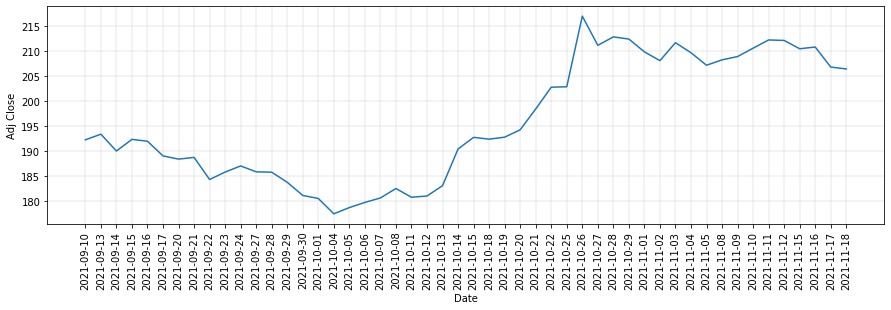

In [4]:
# lets plot the trend of last 45 days (approx 1.5 months of data)

plt.rcParams.update({
    "figure.figsize": (15,4),
})

fig, ax = plt.subplots()
sns.lineplot(data = df.tail(50), x = "Date", y = "Adj Close")
plt.grid(linestyle = "-", linewidth = 0.3)
ax.tick_params(axis = "x", rotation = 90)

##### Create More Feature from existing features | Feature Engineering

In [5]:
# Feature Engineering

df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

# Getting 9 more features from given data 

df["Previous7daysClose"] = df.Adj_Close.shift(7)
df["Previous7daysVolume"] = df.Volume.shift(7)
df["Previous15daysClose"] = df.Adj_Close.shift(15)
df["Previous15daysVolume"] = df.Volume.shift(15)
df["PreviousdayClose"] = df.Adj_Close.shift(1)
df["PreviousdayVolume"] = df.Volume.shift(1)

df["DayOfWeek"] = pd.to_datetime(df["Date"]).dt.day_of_week
df["Month"] = pd.to_datetime(df["Date"]).dt.month
df["Week"] = pd.to_datetime(df["Date"]).dt.isocalendar().week
df["Quarter"] = pd.to_datetime(df["Date"]).dt.quarter

data = df[["Adj_Close",
          "Previous7daysClose",
          "Previous7daysVolume",
          "Previous15daysClose",
          "Previous15daysVolume",
          "PreviousdayClose",
          "PreviousdayVolume",
          "DayOfWeek",
          "Month",
          "Week",
          "Quarter",
          "Date"]].dropna()

In [6]:
data

,Adj_Close,Previous7daysClose,Previous7daysVolume,Previous15daysClose,Previous15daysVolume,PreviousdayClose,PreviousdayVolume,DayOfWeek,Month,Week,Quarter,Date
15,52.940414,52.955322,4107400.0,50.831738,4399200.0,53.529053,4156600.0,1,12,50,4,2011-12-13
16,52.634907,53.611015,4760000.0,50.697628,3331300.0,52.940414,5511200.0,2,12,50,4,2011-12-14
17,53.312969,53.499245,3468500.0,49.848202,5294900.0,52.634907,4714700.0,3,12,50,4,2011-12-15
18,53.469456,54.624371,7583000.0,49.520336,1690700.0,53.312969,6363900.0,4,12,50,4,2011-12-16
19,52.754135,53.663177,5756800.0,50.846638,4618600.0,53.469456,6937500.0,0,12,51,4,2011-12-19
...,...,...,...,...,...,...,...,...,...,...,...,...
2511,212.141876,211.694092,1765800.0,202.807999,3735900.0,212.241379,2113700.0,4,11,45,4,2021-11-12
2512,210.480087,209.684021,2451900.0,202.897552,4829700.0,212.141876,1600300.0,0,11,46,4,2021-11-15
2513,210.828369,207.196320,2117800.0,216.997894,6596500.0,210.480087,1378300.0,1,11,46,4,2021-11-16
2514,206.828140,208.271011,2166100.0,211.166702,3309000.0,210.828369,2302800.0,2,11,46,4,2021-11-17


#### Create Data Pipeline | Create Dataframe mapper | Evaluate Stats model | Check R-squared | Check Coef

In [7]:
label = "Adj_Close"

num_features = [
                "Previous7daysClose",
                "Previous7daysVolume",
                "Previous15daysClose",
                "Previous15daysVolume",
                "PreviousdayClose",
                "PreviousdayVolume"]

cat_features = ["DayOfWeek",
                "Month",
                "Week",
                "Quarter"]

TrainDf, TestDf = train_test_split(data, test_size=0.1, shuffle=False)

X_train, y_train = TrainDf[cat_features + num_features], TrainDf[label]
X_test, y_test = TestDf[cat_features + num_features], TestDf[label]

num = [([n], [StandardScaler()]) for n in num_features]
cat = [([n], [OrdinalEncoder()]) for n in cat_features]
mapper = DataFrameMapper(num + cat, df_out=True)

smXtrain = mapper.fit_transform(X_train)
smXtrain = sm.add_constant(smXtrain)

results = sm.OLS(y_train, smXtrain).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj_Close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 5.280e+04
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:41:56   Log-Likelihood:                -3890.1
No. Observations:                2250   AIC:                             7802.
Df Residuals:                    2239   BIC:                             7865.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   88.6602      0.077   1152.028      0.000      88.509      88.811
Previous7daysClose       0.2820      0.255      1.106      0.269      -0.218       0.782
Previous7daysVolume      0.0517      0.030      1.711      0.087      -0.008       0.111
Previous15daysClose     -0.2544      0.157     -1.623      0.105      -0.562       0.053
Previous15daysVolume    -0.0073      0.030     -0.244      0.807      -0.066       0.051
PreviousdayClose        20.8993      0.186    112.232      0.000      20.534      21.264
PreviousdayVolume       -0.0103      0.030     -0.345      0.730      -0.069       0.048
DayOfWeek                0.0025      0.021      0.121      0.903      -0.038       0.043
Month                   -0.0082      0.049     -0.166      0.868      -0.105       0.089
Week                    -0.0003      0.009     -0.036      0.971      -0.017       0.017
Quarter                  0.0584      0.109      0.536      0.592      -0.155       0.272
==============================================================================
Omnibus:                      661.632   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61403.416
Skew:                           0.338   Prob(JB):                         0.00
Kurtosis:                      28.583   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Create ML Model | Evaluate ML Model

In [8]:
mapper = DataFrameMapper(num + cat, df_out=True)
clf = LinearRegression()
pipeline = Pipeline([
    ("preprocess", mapper),
    ("classifier", clf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_pred), "$")
print("MAE Percentage", mean_absolute_percentage_error(y_test, y_pred) * 100, "%")

MAE 1.9748714019083178 $
MAE Percentage 1.0789137067841152 %


In [9]:
UPS_Prediction = pd.DataFrame(data = {
    "Date": TestDf["Date"].reset_index().drop('index', axis=1)['Date'],
    "pred": y_pred,
    "truth" : y_test.reset_index().drop('index', axis=1)[label]
})
UPS_Prediction.head()

,Date,pred,truth
0,2020-11-20,163.125766,160.310532
1,2020-11-23,160.418754,163.090744
2,2020-11-24,163.118688,169.052460
3,2020-11-25,169.187931,166.908569
4,2020-11-27,167.033085,165.332489


##### Plot Prediction -- Whats going wrong?

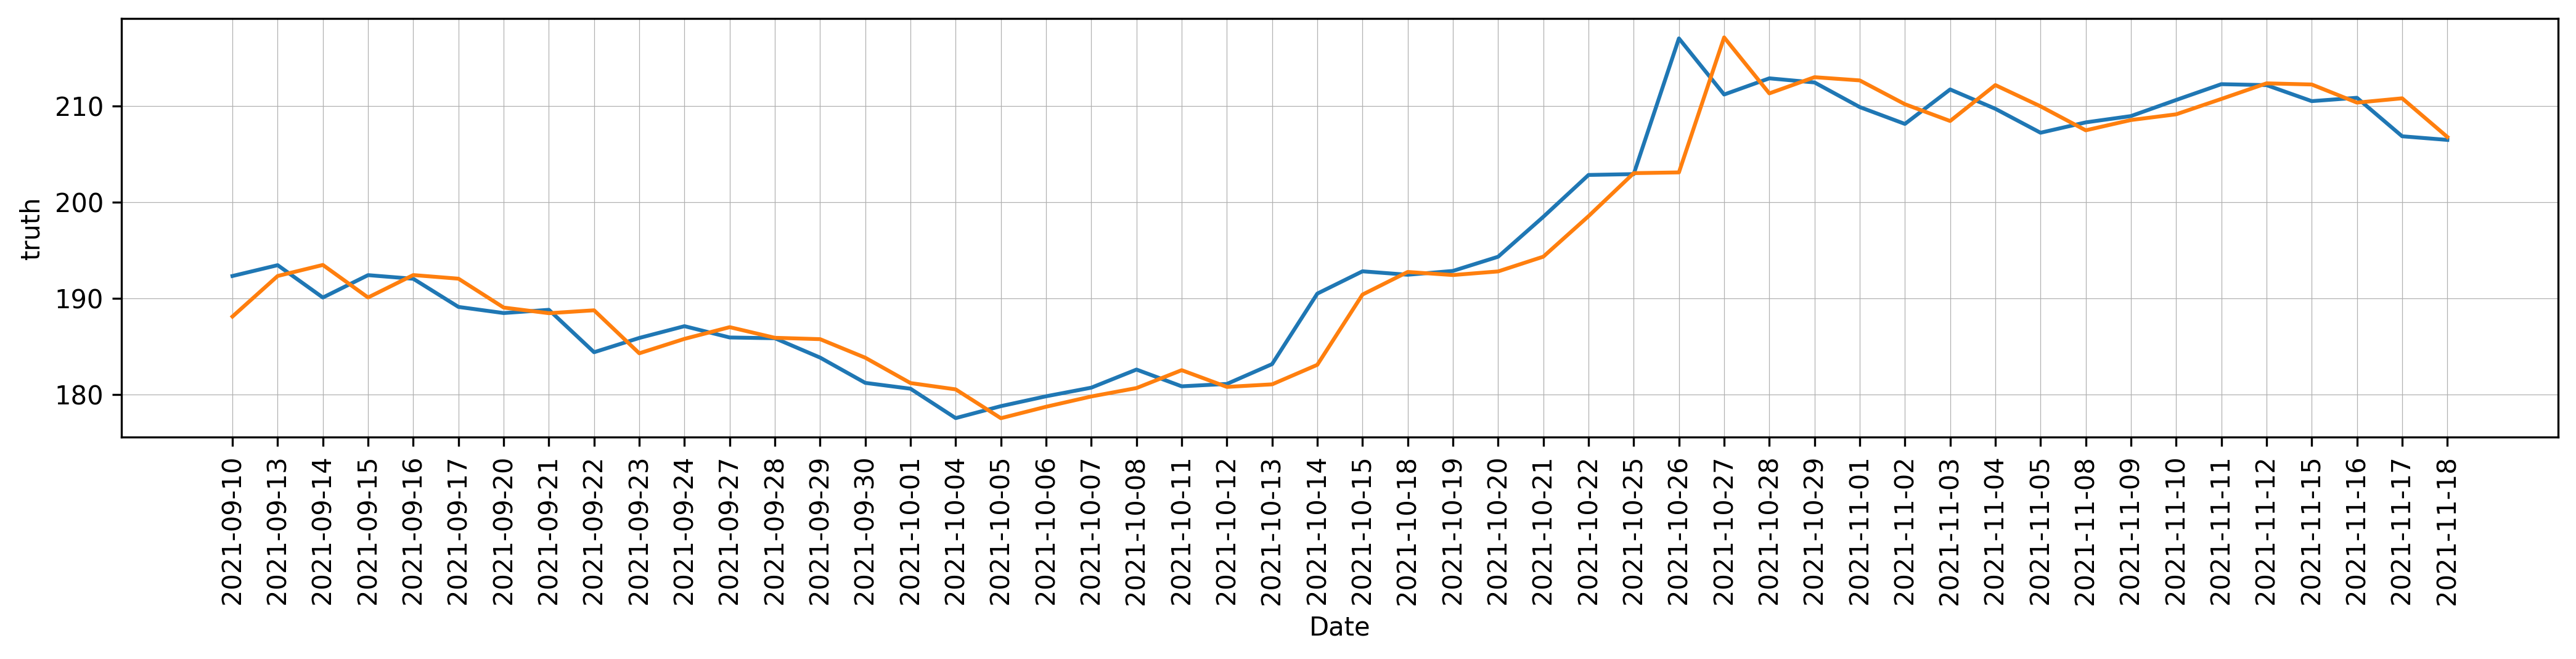

In [10]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=UPS_Prediction.tail(50), x='Date', y='truth')
sns.lineplot(data=UPS_Prediction.tail(50), x='Date', y='pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [11]:
UPS_Prediction.tail(10)

,Date,pred,truth
241,2021-11-05,209.939263,207.196320
242,2021-11-08,207.447259,208.271011
243,2021-11-09,208.516462,208.927765
244,2021-11-10,209.110513,210.599503
245,2021-11-11,210.706569,212.241379
246,2021-11-12,212.328448,212.141876
247,2021-11-15,212.208755,210.480087
248,2021-11-16,210.326480,210.828369
249,2021-11-17,210.773713,206.828140
250,2021-11-18,206.756134,206.449997


##### Visualization of error

In [12]:
TestDf['perc_change'] = (((TestDf['Adj_Close'] - TestDf['PreviousdayClose']) * 100) / TestDf['PreviousdayClose']).abs()
UPS_Prediction = UPS_Prediction.merge(TestDf[['Date', 'perc_change']], on='Date')
UPS_Prediction.sample()

,Date,pred,truth,perc_change
70,2021-03-05,157.004967,161.956024,3.104415


In [13]:
performance = []
for perc_change in np.arange(0, 10, 0.5):
    test = UPS_Prediction[UPS_Prediction['perc_change'] > perc_change]
    
    performance.append({
        'perc_change': perc_change,
        'MAE':  mean_absolute_error(test['truth'], test['pred']),
        'MAPE':  mean_absolute_percentage_error(test['truth'], test['pred']),
        'count': test.shape[0]
    })
    
results = pd.DataFrame(performance)

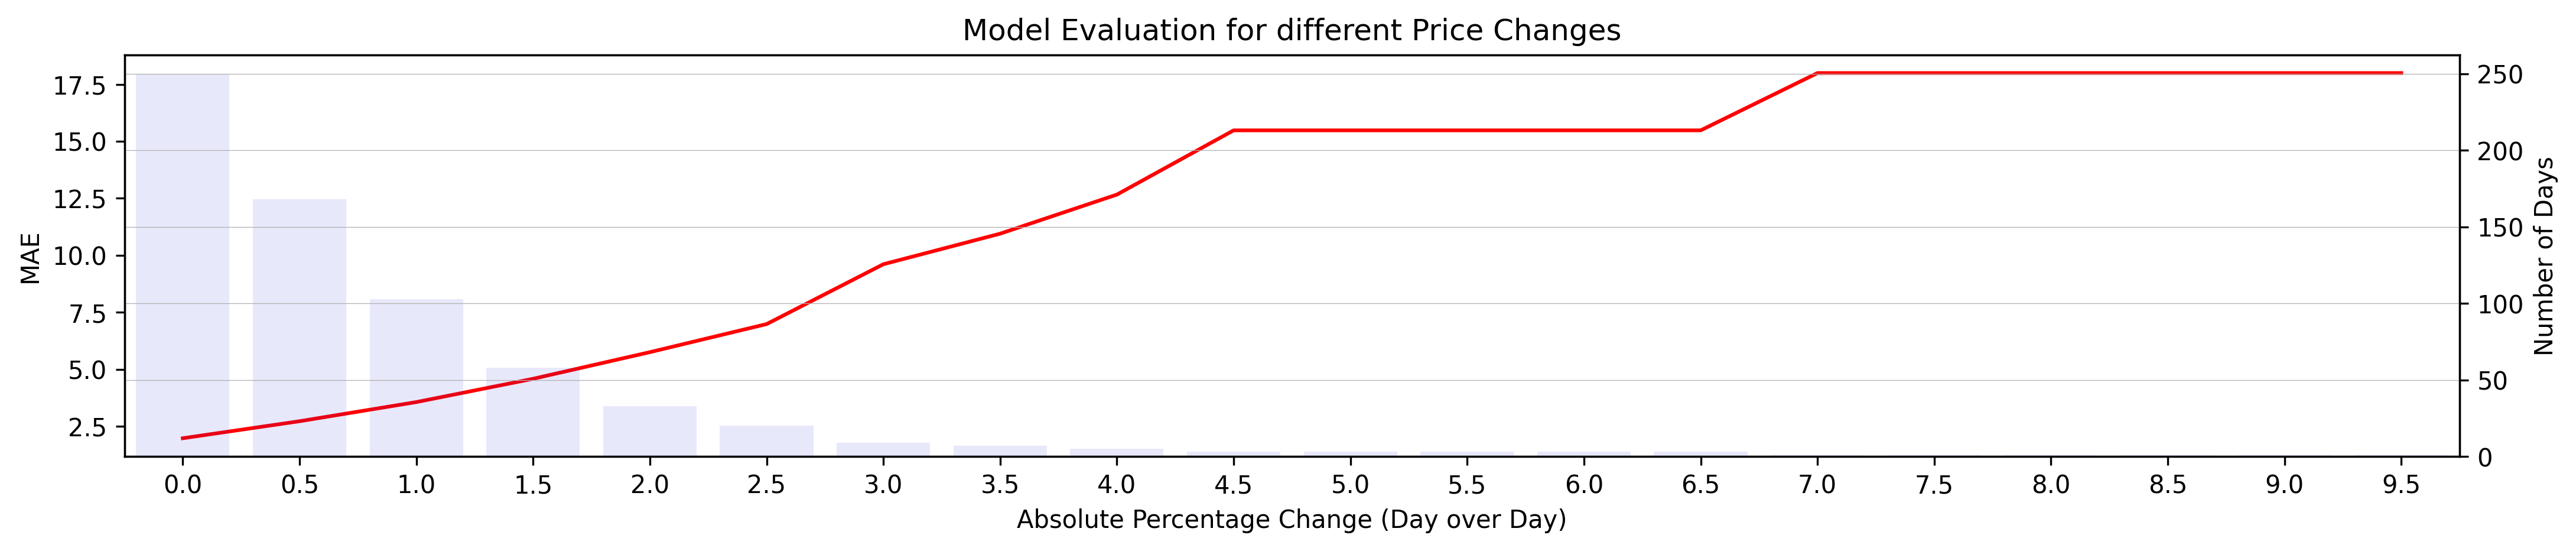

In [14]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAE')


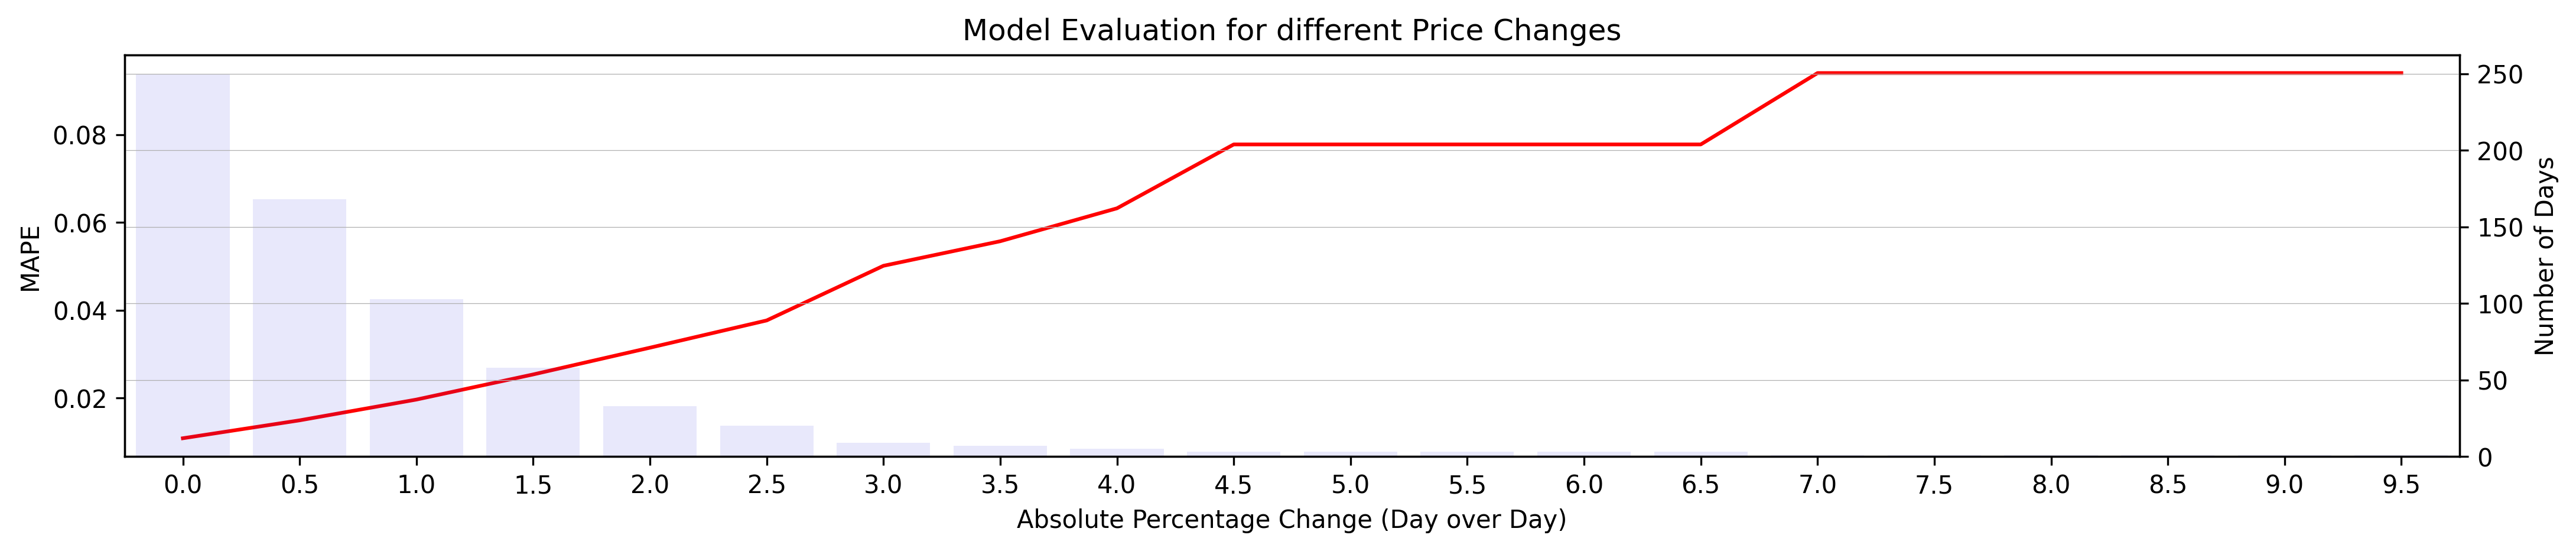

In [15]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi': 300})
fig, ax = plt.subplots()
ax2 = ax.twinx()

sns.lineplot(
    data=results['MAPE'],
    color='red',
    legend=True,
    ax=ax)

sns.barplot(
    x='perc_change',
    y='count',
    data=results,
    color='blue',
    alpha=0.1,
    ax=ax2
)

plt.grid(linestyle='-', linewidth=0.3)
title = ax.set_title('Model Evaluation for different Price Changes')
xlabel = ax.set_xlabel('Absolute Percentage Change (Day over Day)')
ylabel = ax2.set_ylabel('Number of Days')
y2label = ax.set_ylabel('MAPE')


##### Get data from google trend

In [16]:
def _fetch_data(trendreq, kw_list, timeframe='today 3-m', cat=0, geo='', gprop='') -> pd.DataFrame:
    
    """Download google trends data using pytrends TrendReq and retries in case of a ResponseError."""
    attempts, fetched = 0, False
    while not fetched:
        try:
            trendreq.build_payload(kw_list=kw_list, timeframe=timeframe, cat=cat, geo=geo, gprop=gprop)
        except ResponseError as err:
            print(err)
            print(f'Trying again in {60 + 5 * attempts} seconds.')
            sleep(60 + 5 * attempts)
            attempts += 1
            if attempts > 3:
                print('Failed after 3 attemps, abort fetching.')
                break
        else:
            fetched = True
    return trendreq.interest_over_time()

def get_daily_trend(trendreq, keyword:str, start:str, end:str, cat=0, 
                    geo='', gprop='', delta=269, overlap=100, sleep=0, 
                    tz=0, verbose=False) ->pd.DataFrame:

    """Stich and scale consecutive daily trends data between start and end date.
    This function will first download piece-wise google trends data and then 
    scale each piece using the overlapped period. 
        Parameters
        ----------
        trendreq : TrendReq
            a pytrends TrendReq object
        keyword: str
            currently only support single keyword, without bracket
        start: str
            starting date in string format:YYYY-MM-DD (e.g.2017-02-19)
        end: str
            ending date in string format:YYYY-MM-DD (e.g.2017-02-19)
        cat, geo, gprop, sleep: 
            same as defined in pytrends
        delta: int
            The length(days) of each timeframe fragment for fetching google trends data, 
            need to be <269 in order to obtain daily data.
        overlap: int
            The length(days) of the overlap period used for scaling/normalization
        tz: int
            The timezone shift in minute relative to the UTC+0 (google trends default).
            For example, correcting for UTC+8 is 480, and UTC-6 is -360 
    """
    
    start_d = datetime.strptime(start, '%Y-%m-%d')
    init_end_d = end_d = datetime.strptime(end, '%Y-%m-%d')
    init_end_d.replace(hour=23, minute=59, second=59)    
    delta = timedelta(days=delta)
    overlap = timedelta(days=overlap)

    itr_d = end_d - delta
    overlap_start = None

    df = pd.DataFrame()
    ol = pd.DataFrame()
    
    while end_d > start_d:
        tf = itr_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
        if verbose: print('Fetching \''+keyword+'\' for period:'+tf)
        temp = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        temp.drop(columns=['isPartial'], inplace=True)
        temp.columns.values[0] = tf
        ol_temp = temp.copy()
        ol_temp.iloc[:,:] = None
        if overlap_start is not None:  # not first iteration
            if verbose: print('Normalize by overlapping period:'+overlap_start.strftime('%Y-%m-%d'), end_d.strftime('%Y-%m-%d'))
            #normalize using the maximum value of the overlapped period
            y1 = temp.loc[overlap_start:end_d].iloc[:,0].values.max()
            y2 = df.loc[overlap_start:end_d].iloc[:,-1].values.max()
            coef = y2/y1
            temp = temp * coef
            ol_temp.loc[overlap_start:end_d, :] = 1 

        df = pd.concat([df,temp], axis=1)
        ol = pd.concat([ol, ol_temp], axis=1)
        # shift the timeframe for next iteration
        overlap_start = itr_d
        end_d -= (delta-overlap)
        itr_d -= (delta-overlap)
        # in case of short query interval getting banned by server
        time.sleep(sleep)
    
    df.sort_index(inplace=True)
    ol.sort_index(inplace=True)
    #The daily trend data is missing the most recent 3-days data, need to complete with hourly data
    if df.index.max() < init_end_d : 
        tf = 'now 7-d'
        hourly = _fetch_data(trendreq, [keyword], timeframe=tf, cat=cat, geo=geo, gprop=gprop)
        hourly.drop(columns=['isPartial'], inplace=True)
        
        #convert hourly data to daily data
        daily = hourly.groupby(hourly.index.date).sum()
        
        #check whether the first day data is complete (i.e. has 24 hours)
        daily['hours'] = hourly.groupby(hourly.index.date).count()
        if daily.iloc[0].loc['hours'] != 24: daily.drop(daily.index[0], inplace=True)
        daily.drop(columns='hours', inplace=True)
        
        daily.set_index(pd.DatetimeIndex(daily.index), inplace=True)
        daily.columns = [tf]
        
        ol_temp = daily.copy()
        ol_temp.iloc[:,:] = None
        # find the overlapping date
        intersect = df.index.intersection(daily.index)
        if verbose: print('Normalize by overlapping period:'+(intersect.min().strftime('%Y-%m-%d'))+' '+(intersect.max().strftime('%Y-%m-%d')))
        # scaling use the overlapped today-4 to today-7 data
        coef = df.loc[intersect].iloc[:,0].max() / daily.loc[intersect].iloc[:,0].max()
        daily = (daily*coef).round(decimals=0)
        ol_temp.loc[intersect,:] = 1
        
        df = pd.concat([daily, df], axis=1)
        ol = pd.concat([ol_temp, ol], axis=1)

    # taking averages for overlapped period
    df = df.mean(axis=1)
    ol = ol.max(axis=1)
    # merge the two dataframe (trend data and overlap flag)
    df = pd.concat([df,ol], axis=1)
    df.columns = [keyword,'overlap']
    # Correct the timezone difference
    df.index = df.index + timedelta(minutes=tz)
    df = df[start_d:init_end_d]
    # re-normalized to the overall maximum value to have max =100
    df[keyword] = (100*df[keyword]/df[keyword].max()).round(decimals=0)
    
    return df

##### Use the data in our model as feature

In [17]:
pytrend = TrendReq(hl='en-US')
keyword = 'UPS'

start = df['Date'].min()
end = df['Date'].max()

In [18]:
trends = get_daily_trend(pytrend, keyword, start=start, end=end)
trends_df = trends.reset_index().drop('overlap', axis=1)
trends_df.columns=['Date', 'trend_score']
trends_df['Date'] = trends_df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
data = data.merge(trends_df, on='Date')
data.sample()

,Adj_Close,Previous7daysClose,Previous7daysVolume,Previous15daysClose,Previous15daysVolume,PreviousdayClose,PreviousdayVolume,DayOfWeek,Month,Week,Quarter,Date,trend_score
2023,110.317627,111.74823,4957500.0,111.350319,2762700.0,112.686188,1419500.0,0,12,1,4,2019-12-30,53.0


In [19]:
data[["Date", "Adj_Close", "trend_score"]].head(10)

,Date,Adj_Close,trend_score
0,2011-12-13,52.940414,64.0
1,2011-12-14,52.634907,65.0
2,2011-12-15,53.312969,62.0
3,2011-12-16,53.469456,69.0
4,2011-12-19,52.754135,70.0
5,2011-12-20,54.065525,78.0
6,2011-12-21,53.998478,78.0
7,2011-12-22,54.393379,77.0
8,2011-12-23,54.743595,72.0
9,2011-12-27,54.758499,52.0


##### Evaluate and Visualize Model

In [20]:
num_features.append("trend_score")

train_df, test_df = train_test_split(data, test_size=0.1, shuffle=False)
X_train, y_train = train_df[cat_features + num_features], train_df[label]
X_test, y_test = test_df[cat_features + num_features], test_df[label]

num = [([n], [StandardScaler()]) for n in num_features]
cat = [([n], [OrdinalEncoder()]) for n in cat_features]
mapper = DataFrameMapper(num + cat, df_out=True)

preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
results = sm.OLS(y_train, preprocessed_X_train).fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Adj_Close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.800e+04
Date:                Mon, 22 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:42:07   Log-Likelihood:                -3889.7
No. Observations:                2250   AIC:                             7803.
Df Residuals:                    2238   BIC:                             7872.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   88.6790      0.080   1114.515      0.000      88.523      88.835
Previous7daysClose       0.2836      0.255      1.113      0.266      -0.216       0.783
Previous7daysVolume      0.0509      0.030      1.682      0.093      -0.008       0.110
Previous15daysClose     -0.2413      0.157     -1.533      0.125      -0.550       0.067
Previous15daysVolume    -0.0093      0.030     -0.311      0.756      -0.068       0.049
PreviousdayClose        20.8867      0.187    111.867      0.000      20.521      21.253
PreviousdayVolume       -0.0136      0.030     -0.452      0.651      -0.073       0.045
trend_score              0.0294      0.032      0.930      0.352      -0.033       0.091
DayOfWeek                0.0034      0.021      0.165      0.869      -0.037       0.044
Month                   -0.0158      0.050     -0.316      0.752      -0.114       0.082
Week                    -0.0003      0.009     -0.032      0.974      -0.017       0.017
Quarter                  0.0720      0.110      0.655      0.512      -0.144       0.288
==============================================================================
Omnibus:                      658.437   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            60999.932
Skew:                           0.327   Prob(JB):                         0.00
Kurtosis:                      28.500   Cond. No.                         331.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
mapper = DataFrameMapper(num + cat, df_out=True)
clf = LinearRegression()
pipeline = Pipeline([
    ("preprocess", mapper),
    ("classifier", clf)
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("MAE", mean_absolute_error(y_test, y_pred), "$")
print("MAE Percentage", mean_absolute_percentage_error(y_test, y_pred) * 100, "%")

MAE 1.975969988052479 $
MAE Percentage 1.0796469694766004 %


In [22]:
UPS_Prediction = pd.DataFrame(data = {
    "Date": TestDf["Date"].reset_index().drop('index', axis=1)['Date'],
    "pred": y_pred,
    "truth" : y_test.reset_index().drop('index', axis=1)[label]
})
UPS_Prediction.head()

,Date,pred,truth
0,2020-11-20,163.116229,160.310532
1,2020-11-23,160.420914,163.090744
2,2020-11-24,163.137409,169.052460
3,2020-11-25,169.182396,166.908569
4,2020-11-27,167.000440,165.332489


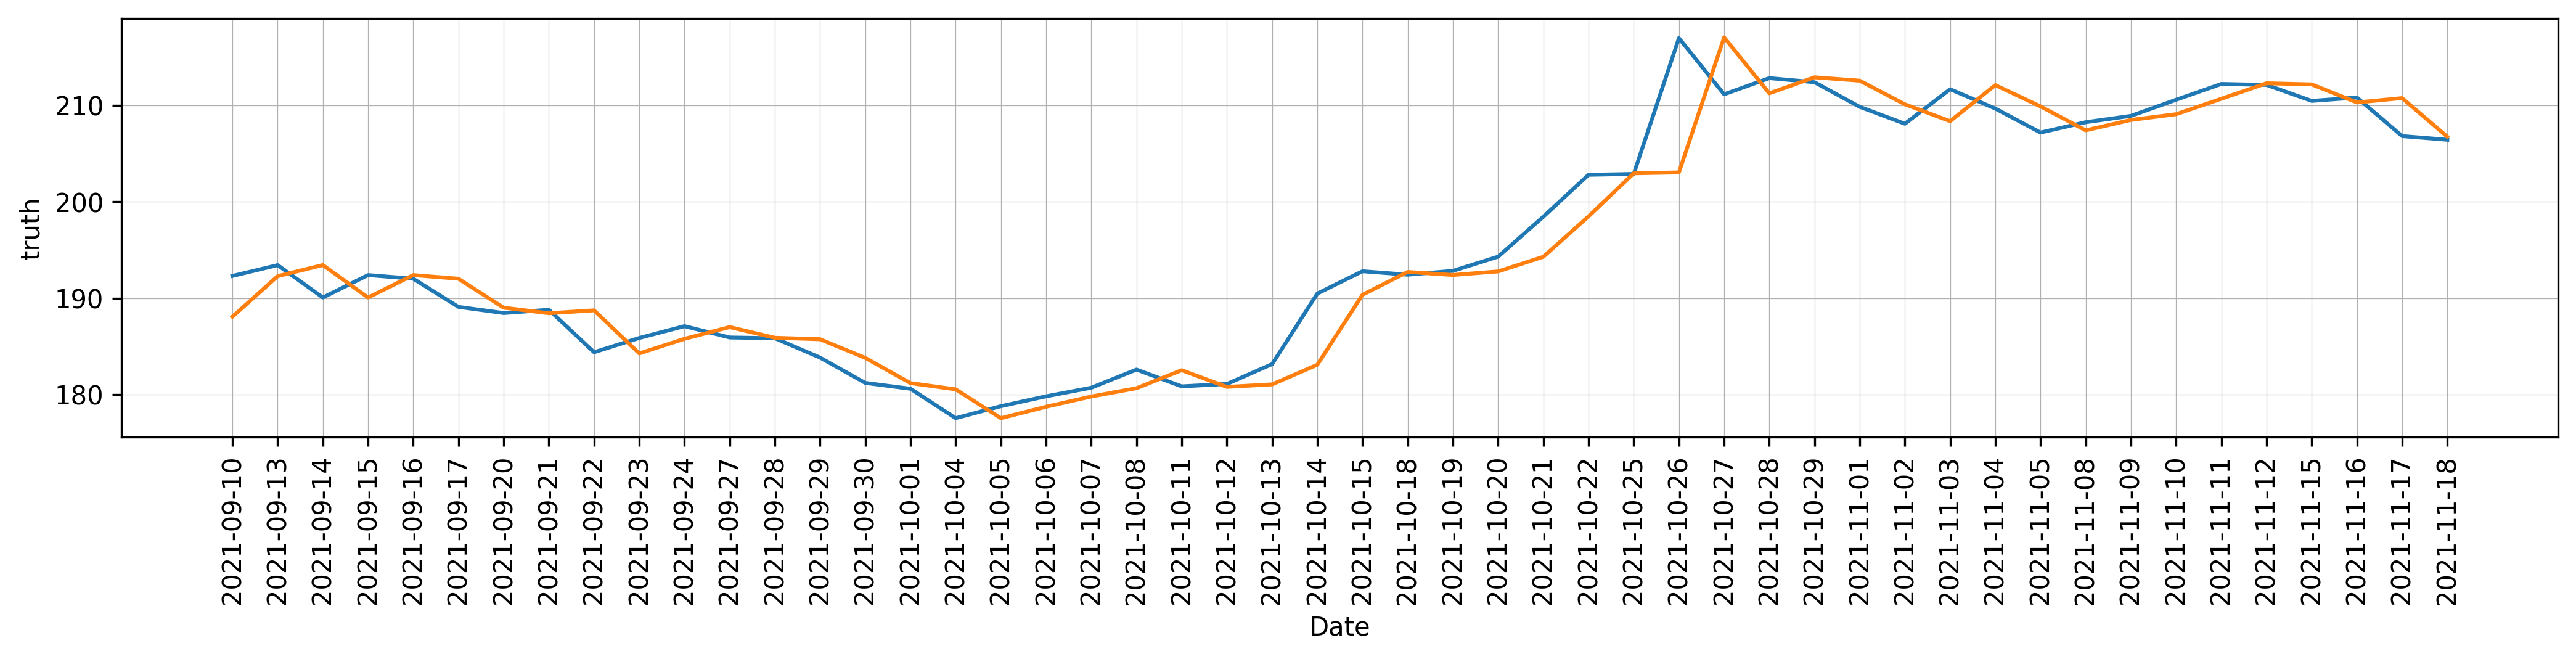

In [23]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=UPS_Prediction.tail(50), x='Date', y='truth')
sns.lineplot(data=UPS_Prediction.tail(50), x='Date', y='pred')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)